In [1]:
import json

# Function to read a .jsonl file
def load_jsonl(file_path):
    with open(file_path, 'r') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

# Load datasets
train_data = load_jsonl("train.jsonl")
valid_data = load_jsonl("valid.jsonl")
test_data = load_jsonl("test.jsonl")

# Inspect the first few examples
print(f"Number of training examples: {len(train_data)}")
print(f"First training example: {train_data[0]}")

Number of training examples: 21854
First training example: {'project': 'FFmpeg', 'commit_id': '973b1a6b9070e2bf17d17568cbaf4043ce931f51', 'target': 0, 'func': 'static av_cold int vdadec_init(AVCodecContext *avctx)\n\n{\n\n    VDADecoderContext *ctx = avctx->priv_data;\n\n    struct vda_context *vda_ctx = &ctx->vda_ctx;\n\n    OSStatus status;\n\n    int ret;\n\n\n\n    ctx->h264_initialized = 0;\n\n\n\n    /* init pix_fmts of codec */\n\n    if (!ff_h264_vda_decoder.pix_fmts) {\n\n        if (kCFCoreFoundationVersionNumber < kCFCoreFoundationVersionNumber10_7)\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts_prior_10_7;\n\n        else\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts;\n\n    }\n\n\n\n    /* init vda */\n\n    memset(vda_ctx, 0, sizeof(struct vda_context));\n\n    vda_ctx->width = avctx->width;\n\n    vda_ctx->height = avctx->height;\n\n    vda_ctx->format = \'avc1\';\n\n    vda_ctx->use_sync_decoding = 1;\n\n    vda_ctx->use_ref_buffer = 1;\n\n    ctx

In [2]:
# Print keys of the first sample
print(train_data[0].keys())

dict_keys(['project', 'commit_id', 'target', 'func', 'idx'])


In [3]:
for i in range(3):  # Print first 3 examples
    print(f"Example {i+1}:")
    print(train_data[i])
    print("\n")

Example 1:
{'project': 'FFmpeg', 'commit_id': '973b1a6b9070e2bf17d17568cbaf4043ce931f51', 'target': 0, 'func': 'static av_cold int vdadec_init(AVCodecContext *avctx)\n\n{\n\n    VDADecoderContext *ctx = avctx->priv_data;\n\n    struct vda_context *vda_ctx = &ctx->vda_ctx;\n\n    OSStatus status;\n\n    int ret;\n\n\n\n    ctx->h264_initialized = 0;\n\n\n\n    /* init pix_fmts of codec */\n\n    if (!ff_h264_vda_decoder.pix_fmts) {\n\n        if (kCFCoreFoundationVersionNumber < kCFCoreFoundationVersionNumber10_7)\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts_prior_10_7;\n\n        else\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts;\n\n    }\n\n\n\n    /* init vda */\n\n    memset(vda_ctx, 0, sizeof(struct vda_context));\n\n    vda_ctx->width = avctx->width;\n\n    vda_ctx->height = avctx->height;\n\n    vda_ctx->format = \'avc1\';\n\n    vda_ctx->use_sync_decoding = 1;\n\n    vda_ctx->use_ref_buffer = 1;\n\n    ctx->pix_fmt = avctx->get_format(avctx, avctx->code

In [4]:
from collections import Counter

# Count classes in the training set
class_counts = Counter([entry['target'] for entry in train_data])
print(f"Class distribution in training set: {class_counts}")

Class distribution in training set: Counter({0: 11836, 1: 10018})


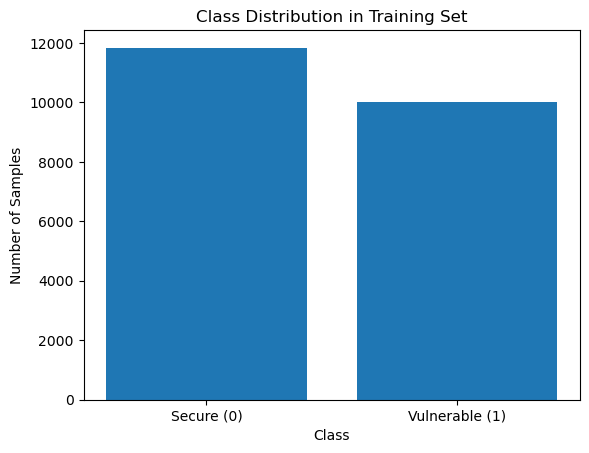

In [5]:
import matplotlib.pyplot as plt

# Plot class distribution
labels = ['Secure (0)', 'Vulnerable (1)']
counts = [class_counts[0], class_counts[1]]

plt.bar(labels, counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [8]:
import json
from transformers import AutoTokenizer

# Load the full dataset
with open("function.json", "r") as f:
    full_dataset = json.load(f)

# Load the train indices
with open("train.txt", "r") as f:
    train_indices = [int(line.strip()) for line in f]

# Extract training samples
train_data = [full_dataset[i] for i in train_indices]
print(f"Extracted {len(train_data)} training samples.")

Extracted 21854 training samples.


In [9]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Function to tokenize the dataset
def tokenize_dataset(data, tokenizer, max_length=512):
    tokenized_data = []
    for entry in data:
        tokens = tokenizer(
            entry['func'],  # Tokenize the "func" field
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        tokenized_data.append({
            "input_ids": tokens["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": entry['target']  # Use the "target" field as the label
        })
    return tokenized_data

# Tokenize the training data
tokenized_train = tokenize_dataset(train_data, tokenizer)
print(f"Tokenized {len(tokenized_train)} training samples.")

Tokenized 21854 training samples.


In [10]:
import torch

# Save the tokenized data
torch.save(tokenized_train, "tokenized_train.pt")
print("Tokenized training data saved to 'tokenized_train.pt'.")

Tokenized training data saved to 'tokenized_train.pt'.


In [11]:
# Extract validation samples
with open("valid.txt", "r") as f:
    valid_indices = [int(line.strip()) for line in f]
valid_data = [full_dataset[i] for i in valid_indices]

# Tokenize validation data
tokenized_valid = tokenize_dataset(valid_data, tokenizer)

# Save tokenized validation data
torch.save(tokenized_valid, "tokenized_valid.pt")
print("Tokenized validation data saved to 'tokenized_valid.pt'.")

# Extract test samples
with open("test.txt", "r") as f:
    test_indices = [int(line.strip()) for line in f]
test_data = [full_dataset[i] for i in test_indices]

# Tokenize test data
tokenized_test = tokenize_dataset(test_data, tokenizer)

# Save tokenized test data
torch.save(tokenized_test, "tokenized_test.pt")
print("Tokenized test data saved to 'tokenized_test.pt'.")

Tokenized validation data saved to 'tokenized_valid.pt'.
Tokenized test data saved to 'tokenized_test.pt'.


In [12]:
# Load the tokenized data
tokenized_train = torch.load("tokenized_train.pt")
print(f"Loaded {len(tokenized_train)} tokenized training samples.")

# Inspect the first sample
print(tokenized_train[0])

Loaded 21854 tokenized training samples.
{'input_ids': tensor([    0, 47908,  1009,   571,  1215, 33869,  1215,   119, 48429,   288,
         1640, 10799,  1215,    90,   295,  1215, 46823,    43, 50118, 50118,
        45152, 50140,  1437,  1437,  1437, 27148, 20401,  1571,  1215, 33407,
         1215,    29,  4291, 30529,  1640,   282,  1215, 46823,  4397, 50140,
         1437,  1437,  1437,   671,   486,  1975,  1640,   134,     6,   295,
         1215, 46823, 45994,   321, 17487,   112,  4832,   295,  1215, 46823,
         4397, 50118, 50118, 24303, 50118,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
         

In [14]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/7b/92/e3f810d0910a71979fe7341803e187cbf85e2b50146c8aa3796eb7bc51b4/accelerate-1.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.21.0 from https://files.pythonhosted.org/packages/44/5a/dc6af87c61f89b23439eb95521e4e99862636cfd538ae12fd36be5483e5f/huggingface_hub-0.26.5-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors>=0.4.3 from https://files.pythonhosted.org/packages/08/8c/ece3bf8756506a890bd980eca02f47f9d98dfbf5ce16eda1368f53560f67/safetensors-0.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [18]:
!export TOKENIZERS_PARALLELISM=false

In [1]:
import urllib3
import botocore

print(f"urllib3 version: {urllib3.__version__}")
print(f"botocore version: {botocore.__version__}")

urllib3 version: 2.2.3
botocore version: 1.35.36


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Step 1: Load the Tokenized Datasets
train_data = torch.load("tokenized_train.pt")  # Ensure this file exists
valid_data = torch.load("tokenized_valid.pt")  # Ensure this file exists

# Step 2: Define a Dataset Class
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": torch.tensor(self.data[idx]["label"]),
        }

# Convert to Dataset format
train_dataset = TokenizedDataset(train_data[:1000])  # Use a subset for light fine-tuning
valid_dataset = TokenizedDataset(valid_data[:200])

# Step 3: Load Pre-trained Model and Tokenizer
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

# Step 4: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./light_finetuned_codebert",  # Directory to save model
    evaluation_strategy="epoch",             # Evaluate at the end of each epoch
    save_strategy="no",                      # Do not save intermediate checkpoints
    num_train_epochs=1,                      # Light fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",                    # Directory for logs
    logging_steps=10,
    load_best_model_at_end=False,            # No need to load the best model
)

# Step 5: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

# Step 6: Fine-Tune the Model
trainer.train()

# Step 7: Save the Fine-Tuned Model
model.save_pretrained("./light_finetuned_codebert")
tokenizer.save_pretrained("./light_finetuned_codebert")

print("Model fine-tuned and saved!")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/1535610713.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("tokenized_train.pt") 

Epoch,Training Loss,Validation Loss
1,0.000000,nan


Model fine-tuned and saved!


In [3]:
def validate_labels(dataset):
    """
    Validate that all labels in the dataset are correctly formatted.
    """
    invalid_labels = []
    for idx, sample in enumerate(dataset):
        label = sample["labels"]
        if not isinstance(label, int) or label not in [0, 1]:
            invalid_labels.append((idx, label))

    if len(invalid_labels) == 0:
        print("All labels are correctly formatted (integers, 0 or 1).")
    else:
        print(f"Found {len(invalid_labels)} invalid labels:")
        for idx, label in invalid_labels[:10]:  # Display up to 10 invalid labels
            print(f"  Sample {idx}: Invalid label '{label}'")
        print("Please fix the invalid labels.")

# Example usage
# Assuming `train_dataset` is your tokenized dataset
validate_labels(train_dataset)

Found 1000 invalid labels:
  Sample 0: Invalid label '1'
  Sample 1: Invalid label '0'
  Sample 2: Invalid label '1'
  Sample 3: Invalid label '0'
  Sample 4: Invalid label '0'
  Sample 5: Invalid label '0'
  Sample 6: Invalid label '0'
  Sample 7: Invalid label '1'
  Sample 8: Invalid label '1'
  Sample 9: Invalid label '0'
Please fix the invalid labels.


In [9]:
def fix_labels(dataset):
    """
    Convert tensor or string labels in the dataset to Python integers.
    """
    for sample in dataset:
        label = sample["labels"]
        # Convert tensor to int if necessary
        if isinstance(label, torch.Tensor):
            sample["labels"] = int(label.item())
        # Convert string to int if necessary
        elif isinstance(label, str):
            sample["labels"] = int(label)
    print("All labels have been converted to integers.")
    return dataset

In [10]:
train_dataset = fix_labels(train_dataset)
valid_dataset = fix_labels(valid_dataset)

All labels have been converted to integers.
All labels have been converted to integers.


In [11]:
validate_labels(train_dataset)

All labels are correctly formatted (integers, 0 or 1).


In [17]:
def __getitem__(self, idx):
    return {
        "input_ids": self.data[idx]["input_ids"],
        "attention_mask": self.data[idx]["attention_mask"],
        "labels": int(self.data[idx]["label"]),  # Convert labels to integers
    }

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
for i in range(5):
    print("Input IDs:", train_dataset[i]["input_ids"])
    print("Attention Mask:", train_dataset[i]["attention_mask"])
    print("Label:", train_dataset[i]["labels"])

Input IDs: tensor([    0, 47908,  1009,   571,  1215, 33869,  1215,   119, 48429,   288,
         1640, 10799,  1215,    90,   295,  1215, 46823,    43, 50118, 50118,
        45152, 50140,  1437,  1437,  1437, 27148, 20401,  1571,  1215, 33407,
         1215,    29,  4291, 30529,  1640,   282,  1215, 46823,  4397, 50140,
         1437,  1437,  1437,   671,   486,  1975,  1640,   134,     6,   295,
         1215, 46823, 45994,   321, 17487,   112,  4832,   295,  1215, 46823,
         4397, 50118, 50118, 24303, 50118,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support

# Step 1: Load the Tokenized Datasets
train_data = torch.load("tokenized_train.pt")  # Ensure this file exists
valid_data = torch.load("tokenized_valid.pt")  # Ensure this file exists

# Step 2: Define a Dataset Class
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": int(self.data[idx]["label"]),  # Ensure labels are integers
        }

# Use full datasets for training and validation
train_dataset = TokenizedDataset(train_data)
valid_dataset = TokenizedDataset(valid_data)

# Step 3: Load Pre-trained Model and Tokenizer
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Step 4: Set Up Dynamic Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Step 5: Define Training Arguments for Full Fine-Tuning
training_args = TrainingArguments(
    output_dir="./improved_finetuned_codebert",  # Directory to save model
    evaluation_strategy="epoch",               # Evaluate at the end of each epoch
    save_strategy="epoch",                     # Save model after each epoch
    save_total_limit=2,                        # Limit saved checkpoints
    num_train_epochs=2,                        # Train for 3 epochs
    per_device_train_batch_size=16,            # Batch size per device
    per_device_eval_batch_size=32,
    learning_rate=2e-5,                        # Learning rate for fine updates
    weight_decay=0.01,
    logging_dir="./logs",                      # Directory for logs
    logging_steps=50,
    no_cuda=True,                              # Use CPU
    fp16=False,                                # Disable mixed precision
)

# Step 6: Define Metrics to Track Class Performance
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = (preds == labels).mean()
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 8: Fine-Tune the Model
trainer.train()

# Step 9: Save the Fine-Tuned Model
model.save_pretrained("./improved_finetuned_codebert")
tokenizer.save_pretrained("./improved_finetuned_codebert")

print("Model fine-tuned and saved!")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/1540600122.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("tokenized_train.pt") 

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'device'

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the Tokenizer and Model
model_dir = "./light_finetuned_codebert"  # Directory where the fine-tuned model is saved
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Step 2: Load the Test Dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists

# Define the Dataset Class for the Test Set
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": int(self.data[idx]["label"]),  # Ensure labels are integers
        }

test_dataset = TokenizedDataset(test_data)

# Step 3: Make Predictions on the Test Set
predictions = []
labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for sample in test_dataset:
        input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)  # Add batch dimension
        attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)  # Add batch dimension
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()
        predictions.append(pred)
        labels.append(sample["labels"])

# Step 4: Calculate Metrics
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Detailed Classification Report
report = classification_report(labels, predictions, target_names=["Secure (0)", "Vulnerable (1)"])
print("\nClassification Report:\n", report)

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/1432259879.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

Accuracy: 54.06%

Classification Report:
                 precision    recall  f1-score   support

    Secure (0)       0.54      1.00      0.70      1477
Vulnerable (1)       0.00      0.00      0.00      1255

      accuracy                           0.54      2732
     macro avg       0.27      0.50      0.35      2732
  weighted avg       0.29      0.54      0.38      2732



/Users/aliasgari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aliasgari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aliasgari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from collections import Counter

train_labels = [sample['label'] for sample in train_data]
valid_labels = [sample['label'] for sample in valid_data]

print("Training Set Label Distribution:", Counter(train_labels))
print("Validation Set Label Distribution:", Counter(valid_labels))

Training Set Label Distribution: Counter({0: 11836, 1: 10018})
Validation Set Label Distribution: Counter({0: 1545, 1: 1187})


In [27]:
!pip install torch torchvision torchaudio

  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/6a/97/1780e3dd8733da30ff1051b8cbd8006e4824b76028558a58c31e790c09cd/torchaudio-2.5.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.5 MB/s eta 0:00:00a 0:00:01


In [28]:
import torch
print(torch.backends.mps.is_available())  # Should return True if MPS is supported

True


In [38]:
## from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support

# Step 1: Load the Tokenized Datasets
train_data = torch.load("tokenized_train.pt")
valid_data = torch.load("tokenized_valid.pt")

# Step 2: Define a Dataset Class
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": int(self.data[idx]["label"]),
        }

# Use full datasets for training and validation
train_dataset = TokenizedDataset(train_data)
valid_dataset = TokenizedDataset(valid_data)

# Step 3: Load Pre-trained Model and Tokenizer
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Set model device to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Step 4: Set Up Dynamic Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./improved_finetuned_codebert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    no_cuda=True,       # Ensure no CUDA is used; MPS or CPU only
    fp16=False,         # Explicitly disable mixed precision
)

# Step 6: Define Metrics to Track Class Performance
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = (preds == labels).mean()
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 8: Fine-Tune the Model
trainer.train()

# Step 9: Save the Fine-Tuned Model
model.save_pretrained("./improved_finetuned_codebert")
tokenizer.save_pretrained("./improved_finetuned_codebert")

print("Model fine-tuned and saved!")


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/1273934276.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("tokenized_train.pt")


Using device: mps


KeyboardInterrupt: 

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset
import torch

# Step 1: Load the Tokenized Datasets
train_data = torch.load("tokenized_train.pt")
valid_data = torch.load("tokenized_valid.pt")

# Step 2: Define Dataset Class
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data[idx]["input_ids"],
            "attention_mask": self.data[idx]["attention_mask"],
            "labels": int(self.data[idx]["label"]),
        }

# Convert to Dataset format
train_dataset = TokenizedDataset(train_data)
valid_dataset = TokenizedDataset(valid_data)

# Step 3: Load Pre-trained Model and Tokenizer
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Step 4: Set Up Dynamic Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./improved_finetuned_codebert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    no_cuda=True,  # Forces CPU usage
    fp16=False,    # Disable mixed precision
)

# Step 6: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
)

# Step 7: Resume Fine-Tuning from Checkpoint
last_checkpoint = "./improved_finetuned_codebert/checkpoint-1366"
trainer.train(resume_from_checkpoint=last_checkpoint)

# Step 8: Save the Fine-Tuned Model
model.save_pretrained("./improved_finetuned_codebert")
tokenizer.save_pretrained("./improved_finetuned_codebert")

print("Fine-tuning resumed and completed. Model saved!")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/4186812653.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("tokenized_train.pt")


Epoch,Training Loss,Validation Loss
2,0.600400,0.585404


Fine-tuning resumed and completed. Model saved!


In [59]:
from transformers import Trainer
from datasets import load_metric

# Assuming `valid_dataset` is your validation dataset
# and `data_collator` is already defined.

# Define compute_metrics function
def compute_metrics(pred):
    metric = load_metric("accuracy")
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    acc = metric.compute(predictions=predictions, references=labels)["accuracy"]

    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Re-initialize Trainer for evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/3475693547.py:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Evaluation Results: {'eval_loss': 0.5854037404060364, 'eval_model_preparation_time': 0.0012, 'eval_accuracy': 0.6489751098096632, 'eval_precision': 0.6881188118811881, 'eval_recall': 0.35130581297388375, 'eval_f1': 0.4651422197434467, 'eval_runtime': 270.15, 'eval_samples_per_second': 10.113, 'eval_steps_per_second': 0.318}


In [61]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from torch.utils.data import Dataset
import torch
import pandas as pd

# Load the fine-tuned model and tokenizer
checkpoint_path = "./improved_finetuned_codebert/checkpoint-2732"  # Path to the final checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Set the model to evaluation mode
model.eval()

# Force PyTorch to use the MPS backend if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Define your test dataset
class TokenizedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.data[idx]["input_ids"]),
            "attention_mask": torch.tensor(self.data[idx]["attention_mask"]),
        }

# Load your test dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
test_dataset = TokenizedDataset(test_data)

# Custom function for predictions with confidence scores
def predict_with_confidence(model, tokenizer, dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)
    results = []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
        
        predicted_labels = probabilities.argmax(axis=-1)
        confidence_scores = probabilities.max(axis=-1)
        
        for idx in range(len(predicted_labels)):
            results.append({
                "input_text": tokenizer.decode(input_ids[idx], skip_special_tokens=True),
                "predicted_label": int(predicted_labels[idx]),
                "confidence_score": float(confidence_scores[idx]),
            })
    
    return results

# Run predictions
predictions = predict_with_confidence(model, tokenizer, test_dataset)

# Save results to a CSV
df_results = pd.DataFrame(predictions)
df_results.to_csv("test_predictions_with_confidence.csv", index=False)

print("Predictions with confidence scores saved to 'test_predictions_with_confidence.csv'.")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/1248137464.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

Predictions with confidence scores saved to 'test_predictions_with_confidence.csv'.


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/556942126.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  # 

Pearson Correlation between confidence and correctness: 0.2779
Spearman Correlation between confidence and correctness: 0.2543


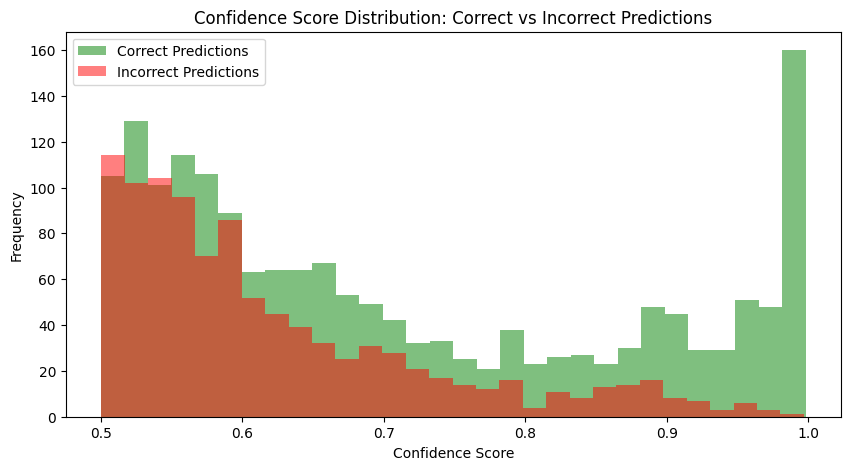

Correct Predictions Confidence Summary:
count    1734.000000
mean        0.709102
std         0.165874
min         0.500049
25%         0.563756
50%         0.656569
75%         0.868148
max         0.997959
Name: confidence_score, dtype: float64

Incorrect Predictions Confidence Summary:
count    998.000000
mean       0.620259
std        0.109946
min        0.500263
25%        0.538501
50%        0.586088
75%        0.670231
max        0.996710
Name: confidence_score, dtype: float64


In [64]:
import pandas as pd
import torch

# Step 1: Load the predictions dataset
df = pd.read_csv("test_predictions_with_confidence.csv")

# Step 2: Load the original test dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
true_labels = [entry["label"] for entry in test_data]  # Extract true labels from the dataset

# Step 3: Add true labels to the DataFrame
df["true_label"] = true_labels

# Step 4: Add Correctness Column
df["is_correct"] = df["predicted_label"] == df["true_label"]

# Step 5: Separate Confidence Scores
correct_confidences = df[df["is_correct"]]["confidence_score"]
incorrect_confidences = df[~df["is_correct"]]["confidence_score"]

# Step 6: Compute Correlation
from scipy.stats import pearsonr, spearmanr
correlation, _ = pearsonr(df["is_correct"], df["confidence_score"])
spearman_corr, _ = spearmanr(df["is_correct"], df["confidence_score"])

print(f"Pearson Correlation between confidence and correctness: {correlation:.4f}")
print(f"Spearman Correlation between confidence and correctness: {spearman_corr:.4f}")

# Step 7: Visualize Confidence Distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(correct_confidences, bins=30, alpha=0.5, label="Correct Predictions", color="green")
plt.hist(incorrect_confidences, bins=30, alpha=0.5, label="Incorrect Predictions", color="red")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Confidence Score Distribution: Correct vs Incorrect Predictions")
plt.show()

# Step 8: Save the updated dataset (optional)
df.to_csv("test_predictions_with_true_labels.csv", index=False)

# Step 9: Summary Statistics
print("Correct Predictions Confidence Summary:")
print(correct_confidences.describe())

print("\nIncorrect Predictions Confidence Summary:")
print(incorrect_confidences.describe())

In [67]:
import numpy as np
import pandas as pd

# Step 1: Load your dataset
df = pd.read_csv("test_predictions_with_confidence.csv")

# Step 2: Ensure the dataset contains the necessary columns
if "confidence_score" not in df.columns:
    raise ValueError("The dataset must include a 'confidence_score' column representing the probability of the predicted class.")

# Step 3: Calculate prediction entropy
def calculate_entropy(row):
    p = row["confidence_score"]  # Confidence for the predicted class
    p = np.clip(p, 1e-12, 1.0)   # Avoid log(0)
    q = 1 - p                    # Confidence for the other class
    entropy = -p * np.log2(p) - q * np.log2(q)
    return entropy

# Add entropy column
df["prediction_entropy"] = df.apply(calculate_entropy, axis=1)

# Step 4: Save the updated dataset
df.to_csv("test_predictions_with_entropy.csv", index=False)

print("Entropy calculation completed. Updated dataset saved as 'test_predictions_with_entropy.csv'.")

Entropy calculation completed. Updated dataset saved as 'test_predictions_with_entropy.csv'.


In [69]:
import pandas as pd
import numpy as np
import torch

# Step 1: Load your dataset
file_path = "test_predictions_with_confidence.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Step 2: Load the original test dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
true_labels = [entry["label"] for entry in test_data]  # Extract true labels from the dataset

# Step 3: Add true labels to the DataFrame
df["true_label"] = true_labels

# Step 4: Add Correctness Column
df["is_correct"] = df["predicted_label"] == df["true_label"]

# Step 5: Separate Confidence Scores
correct_confidences = df[df["is_correct"]]["confidence_score"]
incorrect_confidences = df[~df["is_correct"]]["confidence_score"]

# Step 6: Calculate prediction entropy
def calculate_entropy(confidence_score):
    prob_1 = confidence_score
    prob_0 = 1 - confidence_score
    probabilities = np.array([prob_0, prob_1])
    probabilities = np.clip(probabilities, 1e-12, 1.0)  # Avoid log(0)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

df["prediction_entropy"] = df["confidence_score"].apply(calculate_entropy)

# Step 7: Save the updated dataset
output_file = "test_predictions_with_entropy.csv"
df.to_csv(output_file, index=False)

# Step 8: Correlation with correctness
correlation_pearson = df["prediction_entropy"].corr(df["is_correct"].astype(int))
correlation_spearman = df["prediction_entropy"].corr(df["is_correct"].astype(int), method="spearman")

# Display results
print("Correct Confidence Scores:")
print(correct_confidences.describe())
print("\nIncorrect Confidence Scores:")
print(incorrect_confidences.describe())
print(f"\nPearson Correlation between entropy and correctness: {correlation_pearson:.4f}")
print(f"Spearman Correlation between entropy and correctness: {correlation_spearman:.4f}")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/691980491.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  #

Correct Confidence Scores:
count    1734.000000
mean        0.709102
std         0.165874
min         0.500049
25%         0.563756
50%         0.656569
75%         0.868148
max         0.997959
Name: confidence_score, dtype: float64

Incorrect Confidence Scores:
count    998.000000
mean       0.620259
std        0.109946
min        0.500263
25%        0.538501
50%        0.586088
75%        0.670231
max        0.996710
Name: confidence_score, dtype: float64

Pearson Correlation between entropy and correctness: -0.2811
Spearman Correlation between entropy and correctness: -0.2543


In [70]:
df

,input_text,predicted_label,confidence_score,true_label,is_correct,prediction_entropy
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,1,0.558397,1,True,0.990138
1,static int qcow2_change_backing_file(BlockDriv...,0,0.771769,1,False,0.774915
2,static void simple_whitespace(void)\n\n{\n\n ...,0,0.663211,1,False,0.921713
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,1,0.951676,1,True,0.279236
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0,0.526273,1,False,0.998007
...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,1,0.594357,1,True,0.974156
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,0,0.925011,1,False,0.384273
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",0,0.584445,1,False,0.979326
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",0,0.779009,0,True,0.761973


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
import torch
from transformers import AutoModel, AutoTokenizer

# Step 1: Load Pre-trained Model and Tokenizer
model_name = "./improved_finetuned_codebert"  # Replace with your fine-tuned model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Step 2: Load Dataset
# Ensure "test_predictions_with_confidence.csv" and "tokenized_train.pt" exist
df = pd.read_csv("test_predictions_with_confidence.csv")
test_data = torch.load("tokenized_test.pt")  # Replace with your file path
train_data = torch.load("tokenized_train.pt")  # Replace with your file path

# Decode texts from tokenized datasets
test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]
train_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in train_data]

# Step 3: Extract Latent Representations
def extract_latent_representations(texts, layer=-2, batch_size=32):
    """
    Extract latent representations from the model.
    :param texts: List of text inputs
    :param layer: Layer index to extract representations from
    :param batch_size: Batch size for efficient processing
    :return: Array of latent representations
    """
    latent_representations = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]  # Shape: (batch_size, seq_length, hidden_size)
            batch_representations = hidden_states.mean(dim=1)  # Mean pooling over seq_length
            latent_representations.append(batch_representations.cpu().numpy())
    return np.vstack(latent_representations)

print("Extracting training latent representations...")
train_representations = extract_latent_representations(train_texts)

print("Extracting test latent representations...")
test_representations = extract_latent_representations(test_texts)

# Step 4: Calculate LSA
print("Calculating LSA...")
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(train_representations)
lsa_scores = -kde.score_samples(test_representations)  # Negative log likelihoods

# Step 5: Calculate DSA
print("Calculating DSA...")
distances = np.linalg.norm(test_representations[:, np.newaxis] - train_representations, axis=2)
nearest_distances = np.min(distances, axis=1)  # Min distance to any training sample

scaler = MinMaxScaler()
dsa_scores = scaler.fit_transform(nearest_distances.reshape(-1, 1)).flatten()

# Step 6: Add LSA and DSA to the Dataset
df["lsa_score"] = lsa_scores
df["dsa_score"] = dsa_scores

# Step 7: Save the Updated Dataset
df.to_csv("test_predictions_with_lsa_dsa.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_lsa_dsa.csv'.")

Some weights of RobertaModel were not initialized from the model checkpoint at ./improved_finetuned_codebert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_5494/3461717735.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Extracting training latent representations...
Extracting test latent representations...
Calculating LSA...
Calculating DSA...


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import torch
from transformers import AutoModel, AutoTokenizer

# Use MPS if available, otherwise fall back to CPU
device = torch.device("mps" if torch.has_mps else "cpu")

# Step 1: Load Pre-trained Model and Tokenizer
model_name = "./improved_finetuned_codebert"  # Replace with your fine-tuned model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Step 2: Load Dataset
df = pd.read_csv("test_predictions_with_confidence.csv")
test_data = torch.load("tokenized_test.pt")  # Replace with your file path
train_data = torch.load("tokenized_train.pt")  # Replace with your file path

test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]
train_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in train_data]

# Step 3: Extract Latent Representations
def extract_latent_representations(texts, layer=-2, batch_size=32):
    latent_representations = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]
            batch_representations = hidden_states.mean(dim=1)
            latent_representations.append(batch_representations.cpu().numpy())
    return np.vstack(latent_representations)

print("Extracting training latent representations for LSA...")
train_representations = extract_latent_representations(train_texts)

print("Extracting test latent representations for LSA...")
test_representations = extract_latent_representations(test_texts)

# Step 4: Calculate LSA
print("Calculating LSA...")
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(train_representations)
lsa_scores = -kde.score_samples(test_representations)

# Step 5: Add LSA to the Dataset
df["lsa_score"] = lsa_scores

# Step 6: Save the Updated Dataset
df.to_csv("test_predictions_with_lsa.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_lsa.csv'.")

/Users/aliasgari/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_68638/12414876.py:8: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")
Some weights of RobertaModel were not initialized from the model checkpoint at ./improved_finetuned_codebert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_68638/12414876.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to c

Extracting training latent representations for LSA...
Extracting test latent representations for LSA...
Calculating LSA...
Updated dataset saved as 'test_predictions_with_lsa.csv'.


In [3]:
df

,input_text,predicted_label,confidence_score,lsa_score
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,1,0.558397,210.784513
1,static int qcow2_change_backing_file(BlockDriv...,0,0.771769,211.064370
2,static void simple_whitespace(void)\n\n{\n\n ...,0,0.663211,183.168739
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,1,0.951676,187.846960
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0,0.526273,182.651668
...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,1,0.594357,182.647076
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,0,0.925011,208.740274
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",0,0.584445,259.075386
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",0,0.779009,198.493403


In [4]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Step 1: Load the Dataset with LSA and True Labels
df = pd.read_csv("test_predictions_with_lsa.csv")  # File from the LSA calculation step
test_data = torch.load("tokenized_test.pt")  # Replace with your file path

# Step 2: Extract True Labels
true_labels = [entry["label"] for entry in test_data]
df["true_label"] = true_labels

# Step 3: Add Failure Column
df["is_failure"] = df["predicted_label"] != df["true_label"]

# Step 4: Calculate Correlation
lsa_scores = df["lsa_score"]
failure_indicators = df["is_failure"].astype(int)  # Convert boolean to integer for correlation

# Pearson Correlation
pearson_corr, pearson_p_value = pearsonr(lsa_scores, failure_indicators)

# Spearman Correlation
spearman_corr, spearman_p_value = spearmanr(lsa_scores, failure_indicators)

# Step 5: Print Results
print(f"Pearson Correlation between LSA score and system failure: {pearson_corr:.4f} (p-value: {pearson_p_value:.4e})")
print(f"Spearman Correlation between LSA score and system failure: {spearman_corr:.4f} (p-value: {spearman_p_value:.4e})")

# Optional: Save Updated Dataset
df.to_csv("test_predictions_with_lsa_and_failure.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_lsa_and_failure.csv'.")

Pearson Correlation between LSA score and system failure: -0.0089 (p-value: 6.4343e-01)
Spearman Correlation between LSA score and system failure: -0.0055 (p-value: 7.7524e-01)
Updated dataset saved as 'test_predictions_with_lsa_and_failure.csv'.


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_68638/3412111873.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from transformers import AutoModel, AutoTokenizer

# Use MPS if available, otherwise fall back to CPU
device = torch.device("mps" if torch.has_mps else "cpu")

# Step 1: Load Pre-trained Model and Tokenizer
model_name = "./improved_finetuned_codebert"  # Replace with your fine-tuned model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Step 2: Load Dataset
df = pd.read_csv("test_predictions_with_lsa.csv")  # Use the file from the LSA step
test_data = torch.load("tokenized_test.pt")  # Replace with your file path
train_data = torch.load("tokenized_train.pt")  # Replace with your file path

test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]
train_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in train_data]

# Step 3: Extract Latent Representations
def extract_latent_representations(texts, layer=-2, batch_size=32):
    latent_representations = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]
            batch_representations = hidden_states.mean(dim=1)
            latent_representations.append(batch_representations.cpu().numpy())
    return np.vstack(latent_representations)

print("Extracting training latent representations for DSA...")
train_representations = extract_latent_representations(train_texts)

print("Extracting test latent representations for DSA...")
test_representations = extract_latent_representations(test_texts)

# Step 4: Calculate DSA
print("Calculating DSA...")
distances = np.linalg.norm(test_representations[:, np.newaxis] - train_representations, axis=2)
nearest_distances = np.min(distances, axis=1)

scaler = MinMaxScaler()
dsa_scores = scaler.fit_transform(nearest_distances.reshape(-1, 1)).flatten()

# Step 5: Add DSA to the Dataset
df["dsa_score"] = dsa_scores

# Step 6: Save the Updated Dataset
df.to_csv("test_predictions_with_lsa_dsa.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_lsa_dsa.csv'.")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_68638/567163393.py:8: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")
Some weights of RobertaModel were not initialized from the model checkpoint at ./improved_finetuned_codebert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_68638/567163393.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 

Extracting training latent representations for DSA...
Extracting test latent representations for DSA...
Calculating DSA...


In [2]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Load the fine-tuned model and tokenizer
model_name = "./improved_finetuned_codebert"  # Replace with your model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Load your test dataset (adjust based on your setup)
test_data = torch.load("tokenized_test.pt")  # Replace with your file path

# Decode texts from tokenized test dataset
test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]

# Extract Latent Representations Function
def extract_latent_representations(texts, layer=-2, batch_size=32):
    latent_representations = []
    model.eval()
    model.to("mps")  # Use "mps" for Mac M2 GPU
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to("mps")
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]  # Extract the layer representation
            batch_representations = hidden_states.mean(dim=1)  # Mean pooling over sequence length
            latent_representations.append(batch_representations.cpu().numpy())
    return np.vstack(latent_representations)

# Extract test latent representations
print("Extracting test latent representations...")
test_representations = extract_latent_representations(test_texts)

Some weights of RobertaModel were not initialized from the model checkpoint at ./improved_finetuned_codebert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_75317/946595418.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Extracting test latent representations...


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm

# Load training representations
print("Extracting training latent representations...")
train_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in torch.load("tokenized_train.pt")]
train_representations = extract_latent_representations(train_texts)

# Function to calculate DSA scores in batches
def calculate_dsa_in_batches(test_representations, train_representations, batch_size=100):
    dsa_scores = []
    for i in tqdm(range(0, len(test_representations), batch_size), desc="Calculating DSA in batches"):
        # Select a batch of test representations
        test_batch = test_representations[i:i + batch_size]

        # Compute distances between test batch and all training samples
        distances = np.linalg.norm(test_batch[:, np.newaxis] - train_representations, axis=2)
        
        # Find the minimum distance (nearest neighbor) for each test sample in the batch
        nearest_distances = np.min(distances, axis=1)
        dsa_scores.extend(nearest_distances)
    
    return np.array(dsa_scores)

# Calculate DSA scores
print("Calculating DSA scores...")
raw_dsa_scores = calculate_dsa_in_batches(test_representations, train_representations)

# Normalize DSA scores to range [0, 1]
scaler = MinMaxScaler()
dsa_scores = scaler.fit_transform(raw_dsa_scores.reshape(-1, 1)).flatten()

Extracting training latent representations...


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_75317/1042456602.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_texts = [tokenizer.decode(entry["input_

Calculating DSA scores...


Calculating DSA in batches: 100%|███████████████| 28/28 [06:57<00:00, 14.92s/it]


In [8]:
# Load your existing dataset with predictions
df = pd.read_csv("test_predictions_with_confidence.csv")

# Add DSA scores to the dataset
df["dsa_score"] = dsa_scores

# Save the updated dataset
df.to_csv("test_predictions_with_dsa.csv", index=False)
print("DSA scores added and dataset saved as 'test_predictions_with_dsa.csv'.")

DSA scores added and dataset saved as 'test_predictions_with_dsa.csv'.


In [12]:
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr

# Step 1: Load the dataset with DSA scores and the test dataset
df = pd.read_csv("test_predictions_with_dsa.csv")  # File from the DSA calculation step
test_data = torch.load("tokenized_test.pt")  # Replace with your file path

# Step 2: Extract True Labels from the test dataset
true_labels = [entry["label"] for entry in test_data]
df["true_label"] = true_labels

# Step 3: Add Failure Column
df["is_failure"] = df["predicted_label"] != df["true_label"]

# Step 4: Ensure 'dsa_score' column exists
if "dsa_score" not in df.columns:
    raise ValueError("The dataset must include a 'dsa_score' column with DSA scores.")

# Step 5: Calculate correlations
pearson_corr, pearson_p = pearsonr(df["dsa_score"], df["is_failure"])
spearman_corr, spearman_p = spearmanr(df["dsa_score"], df["is_failure"])

# Step 6: Display results
print(f"Pearson Correlation between DSA score and system failure: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation between DSA score and system failure: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

Pearson Correlation between DSA score and system failure: 0.0154 (p-value: 4.2030e-01)
Spearman Correlation between DSA score and system failure: 0.0020 (p-value: 9.1620e-01)


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_75317/1887554940.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

In [14]:
import numpy as np
import pandas as pd

# Step 1: Load Dataset
df = pd.read_csv("test_predictions_with_confidence.csv")  # Ensure this file contains "confidence_score" column

# Step 2: Parse Confidence Scores
# If confidence scores are in a single column as lists/strings, parse them
if isinstance(df["confidence_score"].iloc[0], str):
    df["confidence_score"] = df["confidence_score"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

# Debugging: Check the structure of the first row of confidence_score
print("Example confidence_score:", df["confidence_score"].iloc[0])

# Step 3: Calculate Prediction Margin
def calculate_margin(confidences):
    if not isinstance(confidences, (list, np.ndarray)) or len(confidences) < 2:
        raise ValueError(f"Invalid confidence scores: {confidences}")
    sorted_confidences = np.sort(confidences)[::-1]  # Sort in descending order
    return sorted_confidences[0] - sorted_confidences[1]  # Difference between highest and second-highest confidence

try:
    df["prediction_margin"] = df["confidence_score"].apply(calculate_margin)
except Exception as e:
    print("Error while calculating prediction margin:", e)
    # Debugging: Print problematic rows
    problematic_rows = df[df["confidence_score"].apply(lambda x: not isinstance(x, (list, np.ndarray)) or len(x) < 2)]
    print("Problematic rows:")
    print(problematic_rows)

# Step 4: Calculate Variance of Probabilities
try:
    df["probability_variance"] = df["confidence_score"].apply(np.var)
except Exception as e:
    print("Error while calculating probability variance:", e)

# Step 5: Save Updated Dataset
df.to_csv("test_predictions_with_aux_vars.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_aux_vars.csv'.")

Example confidence_score: 0.5583972930908203
Error while calculating prediction margin: Invalid confidence scores: 0.5583972930908203
Problematic rows:
                                             input_text  predicted_label  \
0     static void decode_mclms(WmallDecodeCtx *s)\n\...                1   
1     static int qcow2_change_backing_file(BlockDriv...                0   
2     static void simple_whitespace(void)\n\n{\n\n  ...                0   
3     static void pred8x8_top_dc_rv40_c(uint8_t *src...                1   
4     static int32_t bmdma_prepare_buf(IDEDMA *dma, ...                0   
...                                                 ...              ...   
2727  static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...                1   
2728  static void pc_compat_1_4(QEMUMachineInitArgs ...                0   
2729  PCIDevice *pci_nic_init(NICInfo *nd, const cha...                0   
2730  static void gen_exts(int ot, TCGv reg)\n\n{\n\...                0   
2731  int ff

In [16]:
import torch
import pandas as pd

# Load the updated dataset
df = pd.read_csv("test_predictions_with_aux_vars.csv")  # Replace with the correct file name

# Load the original test data to get true labels
test_data = torch.load("tokenized_test.pt")  # Replace with the correct file path
true_labels = [entry["label"] for entry in test_data]  # Extract true labels

# Add true labels to the DataFrame
df["true_label"] = true_labels

# Add 'is_failure' column
df["is_failure"] = df["predicted_label"] != df["true_label"]

# Save the updated dataset
df.to_csv("test_predictions_with_failure_flag.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_failure_flag.csv'.")

Updated dataset saved as 'test_predictions_with_failure_flag.csv'.


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_75317/2369620185.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

In [20]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("test_predictions_with_failure_flag.csv")

# Ensure "confidence_score" exists
if "confidence_score" not in df.columns:
    raise ValueError("The dataset must include a 'confidence_score' column.")

# Calculate prediction margin
df["prediction_margin"] = df["confidence_score"].apply(lambda x: np.abs(x - (1 - x)))

# Save the updated dataset
df.to_csv("test_predictions_with_margin.csv", index=False)
print("Updated dataset saved with 'prediction_margin'.")

Updated dataset saved with 'prediction_margin'.


In [23]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Step 1: Load the dataset
df = pd.read_csv("test_predictions_with_entropy.csv")

# Step 2: Add 'is_failure' Column
df["is_failure"] = df["predicted_label"] != df["true_label"]

# Step 3: Add New Auxiliary Variables
# Calculate prediction_margin
def calculate_margin(confidence_score):
    sorted_confidences = np.array([confidence_score, 1 - confidence_score])  # For binary classification
    sorted_confidences.sort()  # Sort in ascending order
    return sorted_confidences[-1] - sorted_confidences[-2]  # Difference between top two confidences

df["prediction_margin"] = df["confidence_score"].apply(calculate_margin)

# Calculate probability_variance
df["probability_variance"] = df["confidence_score"].apply(lambda x: np.var([x, 1 - x]))

# Step 4: Perform Correlation Analysis
results = {}
for aux_var in ["prediction_margin", "confidence_score", "prediction_entropy"]:
    pearson_corr, pearson_p = pearsonr(df[aux_var], df["is_failure"])
    spearman_corr, spearman_p = spearmanr(df[aux_var], df["is_failure"])
    results[aux_var] = {
        "Pearson Correlation": pearson_corr,
        "Pearson P-value": pearson_p,
        "Spearman Correlation": spearman_corr,
        "Spearman P-value": spearman_p,
    }

# Step 5: Save the Updated Dataset
df.to_csv("test_predictions_with_updated_aux.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_updated_aux.csv'.")

# Display Correlation Results
print("Correlation Analysis Results:")
for aux_var, stats in results.items():
    print(f"Auxiliary Variable: {aux_var}")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value:.4f}")
    print()

Updated dataset saved as 'test_predictions_with_updated_aux.csv'.
Correlation Analysis Results:
Auxiliary Variable: prediction_margin
  Pearson Correlation: -0.2779
  Pearson P-value: 0.0000
  Spearman Correlation: -0.2543
  Spearman P-value: 0.0000

Auxiliary Variable: confidence_score
  Pearson Correlation: -0.2779
  Pearson P-value: 0.0000
  Spearman Correlation: -0.2543
  Spearman P-value: 0.0000

Auxiliary Variable: prediction_entropy
  Pearson Correlation: 0.2811
  Pearson P-value: 0.0000
  Spearman Correlation: 0.2543
  Spearman P-value: 0.0000



In [25]:
import pandas as pd
import numpy as np

# Step 1: Load Dataset
df = pd.read_csv("test_predictions_with_entropy.csv")  # Ensure this file exists

# Step 2: Add Probability Variance
# Assuming "confidence_score" is a single confidence value, we compute the variance as:
# For binary classification, variance = (p * (1-p))
df["probability_variance"] = df["confidence_score"] * (1 - df["confidence_score"])

# Save the updated dataset
df.to_csv("test_predictions_with_entropy.csv", index=False)
print("Probability variance added to the dataset.")

Probability variance added to the dataset.


In [27]:
df

,input_text,predicted_label,confidence_score,true_label,is_correct,prediction_entropy,probability_variance
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,1,0.558397,1,True,0.990138,0.246590
1,static int qcow2_change_backing_file(BlockDriv...,0,0.771769,1,False,0.774915,0.176142
2,static void simple_whitespace(void)\n\n{\n\n ...,0,0.663211,1,False,0.921713,0.223362
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,1,0.951676,1,True,0.279236,0.045989
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0,0.526273,1,False,0.998007,0.249310
...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,1,0.594357,1,True,0.974156,0.241097
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,0,0.925011,1,False,0.384273,0.069366
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",0,0.584445,1,False,0.979326,0.242869
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",0,0.779009,0,True,0.761973,0.172154


In [28]:
from scipy.stats import pearsonr, spearmanr

# Ensure required columns exist
required_columns = ["probability_variance", "is_correct"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"The dataset must include a '{col}' column.")

# Calculate correlations
pearson_corr, pearson_p = pearsonr(df["probability_variance"], df["is_correct"])
spearman_corr, spearman_p = spearmanr(df["probability_variance"], df["is_correct"])

# Display results
print(f"Correlation Analysis Results for Probability Variance with Correctness:")
print(f"  Pearson Correlation: {pearson_corr:.4f}")
print(f"  Pearson P-value: {pearson_p:.4e}")
print(f"  Spearman Correlation: {spearman_corr:.4f}")
print(f"  Spearman P-value: {spearman_p:.4e}")

Correlation Analysis Results for Probability Variance with Correctness:
  Pearson Correlation: -0.2814
  Pearson P-value: 6.7212e-51
  Spearman Correlation: -0.2543
  Spearman P-value: 1.4051e-41


In [30]:
import numpy as np
import pandas as pd

# Step 1: Load the Dataset
df = pd.read_csv("test_predictions_with_entropy.csv")  # Ensure this file exists

# Step 2: Parse Confidence Scores
# Check if `confidence_score` is already a list or array
def parse_confidence_scores(row):
    if isinstance(row["confidence_score"], str):
        return np.array([float(x) for x in row["confidence_score"].split(",")])
    elif isinstance(row["confidence_score"], (list, np.ndarray)):
        return np.array(row["confidence_score"])
    else:
        return np.array([row["confidence_score"]])

df["parsed_confidence_scores"] = df.apply(parse_confidence_scores, axis=1)

# Step 3: Calculate Top-k Confidence Margin
def calculate_top_k_margin(confidences, k=3):
    """
    Calculate the margin between the top-k confidences.
    :param confidences: Array of confidence scores.
    :param k: Number of top confidences to consider.
    :return: Margin between the kth and (k+1)th highest confidences.
    """
    sorted_confidences = np.sort(confidences)[::-1]  # Sort in descending order
    if len(sorted_confidences) >= k + 1:
        return sorted_confidences[k - 1] - sorted_confidences[k]
    return 0.0  # If less than k confidences, return 0

# Calculate Top-3 Margin (You can change `k` as needed)
df["top_3_margin"] = df["parsed_confidence_scores"].apply(calculate_top_k_margin, k=3)

# Step 4: Save the Updated Dataset
df.drop(columns=["parsed_confidence_scores"], inplace=True)  # Clean up temporary column
df.to_csv("test_predictions_with_top_k_margin.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_top_k_margin.csv'.")

Updated dataset saved as 'test_predictions_with_top_k_margin.csv'.


Missing values in dataset:
input_text              0
predicted_label         0
confidence_score        0
true_label              0
is_correct              0
prediction_entropy      0
probability_variance    0
top_3_margin            0
dtype: int64

Unique values in 'top_3_margin':
[0.]

Unique values in 'is_correct':
[ True False]

Data types:
top_3_margin    float64
is_correct         bool
dtype: object


In [33]:
print(df["confidence_score"].head())  # Inspect the original confidence scores

0    0.558397
1    0.771769
2    0.663211
3    0.951676
4    0.526273
Name: confidence_score, dtype: float64


In [34]:
df["prediction_margin"] = abs(df["confidence_score"] - 0.5)

In [35]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(df["prediction_margin"], df["is_correct"])
spearman_corr, spearman_p = spearmanr(df["prediction_margin"], df["is_correct"])

print("Correlation Analysis Results:")
print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

Correlation Analysis Results:
Pearson Correlation: 0.2779 (p-value: 1.2219e-49)
Spearman Correlation: 0.2543 (p-value: 1.4051e-41)


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Step 1: Load the fine-tuned model and tokenizer
model_path = "./improved_finetuned_codebert"  # Replace with your model path
model = AutoModel.from_pretrained(model_path).to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Step 2: Load tokenized datasets
train_data = torch.load("tokenized_train.pt")  # Replace with your file path
test_data = torch.load("tokenized_test.pt")  # Replace with your file path

# Decode texts from tokenized datasets
train_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in train_data]
test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]

# Step 3: Function to extract embeddings
def extract_embeddings(texts, batch_size=32, layer=-2):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]  # Use second-to-last layer
            batch_embeddings = hidden_states.mean(dim=1).cpu().numpy()  # Mean pooling
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Step 4: Extract embeddings
print("Extracting embeddings for training set...")
train_embeddings = extract_embeddings(train_texts)

print("Extracting embeddings for test set...")
test_embeddings = extract_embeddings(test_texts)

# Step 5: Compute cosine similarity
def calculate_cosine_similarity(test_embeddings, train_embeddings, k=5):
    cosine_similarities = []
    for test_emb in tqdm(test_embeddings, desc="Calculating cosine similarity"):
        similarities = cosine_similarity([test_emb], train_embeddings)[0]
        top_k_similarities = np.sort(similarities)[-k:]  # Get top-k similarities
        cosine_similarities.append(np.mean(top_k_similarities))  # Take mean of top-k
    return cosine_similarities

print("Calculating cosine similarities...")
cosine_similarities = calculate_cosine_similarity(test_embeddings, train_embeddings)

# Step 6: Prepare the test set DataFrame
df = pd.read_csv("test_predictions_with_confidence.csv")  # Ensure file exists
test_true_labels = [entry["label"] for entry in test_data]  # Extract true labels

# Add auxiliary information
df["true_label"] = test_true_labels
df["cosine_similarity"] = cosine_similarities
df["is_correct"] = df["predicted_label"] == df["true_label"]

# Step 7: Save updated dataset
df.to_csv("test_predictions_with_all_metrics.csv", index=False)
print("Updated dataset saved as 'test_predictions_with_all_metrics.csv'.")

# Step 8: Correlation Analysis
def correlation_analysis(df, aux_columns, target_column="is_correct"):
    from scipy.stats import pearsonr, spearmanr
    results = {}
    for aux_col in aux_columns:
        pearson_corr, pearson_p = pearsonr(df[aux_col], df[target_column])
        spearman_corr, spearman_p = spearmanr(df[aux_col], df[target_column])
        results[aux_col] = {
            "Pearson Correlation": pearson_corr,
            "Pearson P-value": pearson_p,
            "Spearman Correlation": spearman_corr,
            "Spearman P-value": spearman_p,
        }
    return results

aux_columns = ["confidence_score", "cosine_similarity"]
correlation_results = correlation_analysis(df, aux_columns)

print("Correlation Results:")
for metric, stats in correlation_results.items():
    print(f"Metric: {metric}")
    for key, value in stats.items():
        print(f"  {key}: {value}")


Some weights of RobertaModel were not initialized from the model checkpoint at ./improved_finetuned_codebert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_8177/2681939399.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Extracting embeddings for training set...


Extracting embeddings:   8%|█▌                 | 57/683 [01:13<13:27,  1.29s/it]


KeyboardInterrupt: 

In [39]:
df

,input_text,predicted_label,confidence_score,cosine_similarity
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,1,0.558397,0.955889
1,static int qcow2_change_backing_file(BlockDriv...,0,0.771769,0.870490
2,static void simple_whitespace(void)\n\n{\n\n ...,0,0.663211,0.997331
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,1,0.951676,0.978289
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0,0.526273,0.996433
...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,1,0.594357,0.998611
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,0,0.925011,0.893975
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",0,0.584445,0.913298
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",0,0.779009,0.901658


In [40]:
import pandas as pd
import torch

# Step 1: Load the updated dataset
df = pd.read_csv("test_predictions_with_cosine_similarity.csv")

# Step 2: Load the tokenized test data to extract true labels
test_data = torch.load("tokenized_test.pt")  # Replace with the correct path
true_labels = [entry["label"] for entry in test_data]  # Extract true labels

# Step 3: Add true labels to the DataFrame
df["true_label"] = true_labels

# Step 4: Add Correctness Column
df["is_correct"] = df["predicted_label"] == df["true_label"]

# Save the updated dataset for future use
df.to_csv("test_predictions_with_cosine_similarity_and_labels.csv", index=False)

print("Updated dataset saved as 'test_predictions_with_cosine_similarity_and_labels.csv'.")

Updated dataset saved as 'test_predictions_with_cosine_similarity_and_labels.csv'.


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_75317/1089940041.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

In [4]:
pip install radon

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for radon from https://files.pythonhosted.org/packages/93/f7/d00d9b4a0313a6be3a3e0818e6375e15da6d7076f4ae47d1324e7ca986a1/radon-6.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for mando<0.8,>=0.6 from https://files.pythonhosted.org/packages/d2/f0/834e479e47e499b6478e807fb57b31cc2db696c4db30557bb6f5aea4a90b/mando-0.7.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
# Step 5: Perform Correlation Analysis
required_columns = ["cosine_similarity", "is_correct"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"The dataset must include a '{col}' column.")

pearson_corr, pearson_p = pearsonr(df["cosine_similarity"], df["is_correct"])
spearman_corr, spearman_p = spearmanr(df["cosine_similarity"], df["is_correct"])

# Step 6: Display results
print("Correlation Analysis Results:")
print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

Correlation Analysis Results:
Pearson Correlation: 0.0293 (p-value: 1.2570e-01)
Spearman Correlation: 0.0380 (p-value: 4.6868e-02)


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoTokenizer
from radon.complexity import cc_visit
import ast
import subprocess

# Load Fine-Tuned Model Tokenizer
model_name = "./improved_finetuned_codebert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load Test Dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]

# Create a DataFrame for Metrics
df = pd.DataFrame({"input_text": test_texts})

# Metrics Calculation
def calculate_cyclomatic_complexity(code):
    try:
        results = cc_visit(code)
        return sum(result.complexity for result in results)
    except Exception as e:
        return None

def count_lines_of_code(code):
    return len(code.splitlines())

def count_functions(code):
    try:
        tree = ast.parse(code)
        return sum(isinstance(node, ast.FunctionDef) for node in ast.walk(tree))
    except Exception as e:
        return None

def count_imports(code):
    try:
        tree = ast.parse(code)
        return sum(isinstance(node, (ast.Import, ast.ImportFrom)) for node in ast.walk(tree))
    except Exception as e:
        return None

def count_variables(code):
    try:
        tree = ast.parse(code)
        return sum(isinstance(node, ast.Name) and isinstance(node.ctx, ast.Store) for node in ast.walk(tree))
    except Exception as e:
        return None

def calculate_comment_density(code):
    lines = code.splitlines()
    comments = sum(1 for line in lines if line.strip().startswith("#"))
    return comments / len(lines) if len(lines) > 0 else 0

def run_bandit_on_code(code):
    try:
        with open("temp_code.py", "w") as f:
            f.write(code)
        result = subprocess.run(["bandit", "-f", "json", "temp_code.py"], capture_output=True, text=True)
        return result.stdout
    except Exception as e:
        return None

# Apply Metrics to Dataset
print("Calculating metrics for each code snippet...")
df["cyclomatic_complexity"] = df["input_text"].apply(calculate_cyclomatic_complexity)
df["lines_of_code"] = df["input_text"].apply(count_lines_of_code)
df["function_count"] = df["input_text"].apply(count_functions)
df["import_count"] = df["input_text"].apply(count_imports)
df["variable_count"] = df["input_text"].apply(count_variables)
df["comment_density"] = df["input_text"].apply(calculate_comment_density)
df["security_findings"] = df["input_text"].apply(run_bandit_on_code)

# Save Updated Dataset
df.to_csv("test_metrics.csv", index=False)
print("Metrics added to dataset and saved as 'test_metrics.csv'.")

/Users/aliasgari/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_9354/1332296137.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett

Calculating metrics for each code snippet...
Metrics added to dataset and saved as 'test_metrics.csv'.


In [2]:
df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,None,53,None,None,None,0.0,None
1,static int qcow2_change_backing_file(BlockDriv...,None,9,None,None,None,0.0,None
2,static void simple_whitespace(void)\n\n{\n\n ...,None,45,None,None,None,0.0,None
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,None,27,None,None,None,0.0,None
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",None,51,None,None,None,0.0,None
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,None,37,None,None,None,0.0,None
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,None,13,None,None,None,0.0,None
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",None,35,None,None,None,0.0,None
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",None,31,None,None,None,0.0,None


In [3]:
pip install lizard

  Obtaining dependency information for lizard from https://files.pythonhosted.org/packages/b8/37/8eff5380bd28768529a64391c9ca1f475e7f7308a0b4226f94dda3971fbc/lizard-1.17.13-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
!lizard --version

1.17.13


In [11]:
! brew install cppcheck

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).

This repository is configured for Git LFS but 'git-lfs' was not found on your path. If you no longer wish to use Git LFS, remove this hook by deleting the 'post-checkout' file in the hooks directory (set by 'core.hookspath'; usually '.git/hooks').

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
aws-c-auth                 idsgrep                    sequin
aws-c-mqtt                 imgp                       sfsexp
aws-c-s3                   libsidplayfp               spytrap-adb
aws-crt-cpp                libunicode                 templ
azure-core-cpp             macmon                     tenere
cargo-chef                 mago                       versitygw
cobra-cli                  poselib                    weaviate
fairy-stockfish            

In [12]:
!cppcheck --version

Cppcheck 2.16.0


In [11]:
import lizard
import os
import pandas as pd
from tqdm import tqdm

# Load the test dataset
df = pd.read_csv("test_code_metrics.csv")  # File created earlier

# Directory for temporary files
temp_dir = "./temp_code_files"
os.makedirs(temp_dir, exist_ok=True)

# Function to validate code snippets
def is_valid_c_function(code):
    return "{" in code and ("int" in code or "void" in code or "static" in code)

# Extract metrics for each input_text
metrics = []
for i, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing code with Lizard"):
    if not is_valid_c_function(row["input_text"]):
        print(f"Skipping record {i}: Not valid C function")
        metrics.append({
            "file_index": i,
            "function_name": None,
            "cyclomatic_complexity": None,
            "lines_of_code": None,
            "parameter_count": None
        })
        continue  # Skip invalid code
    
    # Save each input_text to a temporary .c file
    file_path = os.path.join(temp_dir, f"snippet_{i}.c")
    with open(file_path, "w") as f:
        f.write(row["input_text"])
    
    # Analyze the file with Lizard
    analysis = lizard.analyze_file(file_path)
    
    # Collect metrics
    if analysis.function_list:  # Functions in the file
        for func in analysis.function_list:
            metrics.append({
                "file_index": i,
                "function_name": func.name,
                "cyclomatic_complexity": func.cyclomatic_complexity,
                "lines_of_code": func.length,
                "parameter_count": func.parameter_count
            })
    else:  # No functions, but valid code
        metrics.append({
            "file_index": i,
            "function_name": None,
            "cyclomatic_complexity": None,
            "lines_of_code": analysis.nloc,
            "parameter_count": None
        })

# Create a DataFrame for the metrics
df_metrics = pd.DataFrame(metrics)

# Handle NaN values (e.g., fill with 0 or drop rows)
df_metrics.fillna(0, inplace=True)

# Aggregate metrics back into the original DataFrame
for col in ["cyclomatic_complexity", "lines_of_code"]:
    df[col] = df_metrics.groupby("file_index")[col].mean()

# Save the updated DataFrame
df.to_csv("test_code_metrics_with_validation.csv", index=False)
print("Metrics extracted and saved as 'test_code_metrics_with_validation.csv'.")

Analyzing code with Lizard:  15%|█▍        | 406/2732 [00:00<00:01, 2056.94it/s]

Skipping record 7: Not valid C function
Skipping record 35: Not valid C function
Skipping record 74: Not valid C function
Skipping record 103: Not valid C function
Skipping record 140: Not valid C function
Skipping record 173: Not valid C function
Skipping record 180: Not valid C function
Skipping record 276: Not valid C function
Skipping record 294: Not valid C function
Skipping record 383: Not valid C function
Skipping record 412: Not valid C function


Analyzing code with Lizard:  31%|███       | 839/2732 [00:00<00:00, 2133.24it/s]

Skipping record 446: Not valid C function
Skipping record 658: Not valid C function
Skipping record 660: Not valid C function
Skipping record 696: Not valid C function
Skipping record 709: Not valid C function
Skipping record 829: Not valid C function


Analyzing code with Lizard:  47%|████▏    | 1279/2732 [00:00<00:00, 2167.38it/s]

Skipping record 884: Not valid C function
Skipping record 897: Not valid C function
Skipping record 899: Not valid C function
Skipping record 901: Not valid C function
Skipping record 1021: Not valid C function
Skipping record 1085: Not valid C function
Skipping record 1099: Not valid C function
Skipping record 1111: Not valid C function
Skipping record 1225: Not valid C function
Skipping record 1237: Not valid C function
Skipping record 1308: Not valid C function
Skipping record 1314: Not valid C function


Analyzing code with Lizard:  64%|█████▋   | 1735/2732 [00:00<00:00, 2222.96it/s]

Skipping record 1388: Not valid C function
Skipping record 1404: Not valid C function
Skipping record 1424: Not valid C function
Skipping record 1570: Not valid C function
Skipping record 1577: Not valid C function
Skipping record 1652: Not valid C function
Skipping record 1654: Not valid C function
Skipping record 1695: Not valid C function
Skipping record 1736: Not valid C function
Skipping record 1739: Not valid C function


Analyzing code with Lizard:  88%|███████▉ | 2417/2732 [00:01<00:00, 2254.18it/s]

Skipping record 2018: Not valid C function
Skipping record 2038: Not valid C function
Skipping record 2123: Not valid C function
Skipping record 2124: Not valid C function
Skipping record 2169: Not valid C function
Skipping record 2224: Not valid C function
Skipping record 2233: Not valid C function
Skipping record 2246: Not valid C function
Skipping record 2295: Not valid C function
Skipping record 2393: Not valid C function
Skipping record 2450: Not valid C function
Skipping record 2453: Not valid C function


Analyzing code with Lizard: 100%|█████████| 2732/2732 [00:01<00:00, 2207.83it/s]

Skipping record 2498: Not valid C function
Skipping record 2501: Not valid C function
Skipping record 2505: Not valid C function
Skipping record 2570: Not valid C function
Skipping record 2610: Not valid C function
Skipping record 2611: Not valid C function
Skipping record 2634: Not valid C function
Skipping record 2648: Not valid C function
Skipping record 2678: Not valid C function
Metrics extracted and saved as 'test_code_metrics_with_validation.csv'.


In [12]:
df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,7.0,53.0,NaN,NaN,NaN,NaN,NaN
1,static int qcow2_change_backing_file(BlockDriv...,1.0,9.0,NaN,NaN,NaN,NaN,NaN
2,static void simple_whitespace(void)\n\n{\n\n ...,0.0,22.0,NaN,NaN,NaN,NaN,NaN
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,3.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0.0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,0.0,18.0,NaN,NaN,NaN,NaN,NaN
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,1.0,13.0,NaN,NaN,NaN,NaN,NaN
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",3.0,35.0,NaN,NaN,NaN,NaN,NaN
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",4.0,31.0,NaN,NaN,NaN,NaN,NaN


In [14]:
df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,7.0,53.0,NaN,NaN,NaN,NaN,NaN
1,static int qcow2_change_backing_file(BlockDriv...,1.0,9.0,NaN,NaN,NaN,NaN,NaN
2,static void simple_whitespace(void)\n\n{\n\n ...,0.0,22.0,NaN,NaN,NaN,NaN,NaN
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,3.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0.0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,0.0,18.0,NaN,NaN,NaN,NaN,NaN
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,1.0,13.0,NaN,NaN,NaN,NaN,NaN
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",3.0,35.0,NaN,NaN,NaN,NaN,NaN
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",4.0,31.0,NaN,NaN,NaN,NaN,NaN


In [18]:
missing_metrics = df[df["cyclomatic_complexity"].isna()]
print(missing_metrics["input_text"])

2       static void simple_whitespace(void)\n\n{\n\n  ...
4       static int32_t bmdma_prepare_buf(IDEDMA *dma, ...
5       int pcistb_service_call(S390CPU *cpu, uint8_t ...
6       static void do_interrupt_protected(CPUX86State...
8       static int read_thread(void *arg)\n\n{\n\n    ...
                              ...                        
2722    int ff_jni_exception_get_summary(JNIEnv *env, ...
2723    static void file_completion(const char *input)...
2726    void dsputil_init_arm(DSPContext* c, AVCodecCo...
2727    static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...
2731    int ff_h264_alloc_tables(H264Context *h){\n\n ...
Name: input_text, Length: 1373, dtype: object


In [19]:
def is_valid_c_function(code):
    return "{" in code and ("int" in code or "void" in code or "static" in code)

In [32]:
import subprocess
import os
from tqdm import tqdm

# Prepare for CppCheck Analysis
cppcheck_data = []

for i, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing code with CppCheck"):
    # Save each input_text to a temporary .c file
    file_path = os.path.join(temp_dir, f"snippet_{i}.c")
    with open(file_path, "w") as f:
        f.write(row["input_text"])
    
    # Run CppCheck on the file
    result = subprocess.run(
        ["cppcheck", "--enable=all", "--xml", file_path],
        capture_output=True, text=True
    )
    
    # Parse XML output (basic implementation)
    for line in result.stderr.split("\n"):
        if "<error " in line:
            error_type = line.split('id="')[1].split('"')[0]
            severity = line.split('severity="')[1].split('"')[0]
            message = line.split('msg="')[1].split('"')[0]
            cppcheck_data.append({
                "file_index": i,
                "error_type": error_type,
                "severity": severity,
                "message": message
            })

# Create a DataFrame for CppCheck findings
df_cppcheck = pd.DataFrame(cppcheck_data)

# Aggregate security findings back into the main DataFrame
df["security_findings"] = df_cppcheck.groupby("file_index")["error_type"].apply(list)

# Save the updated DataFrame
df.to_csv("test_code_metrics_with_cppcheck.csv", index=False)
print("Security findings extracted and saved as 'test_code_metrics_with_cppcheck.csv'.")

Analyzing code with CppCheck: 100%|█████████| 2732/2732 [00:34<00:00, 78.11it/s]

Security findings extracted and saved as 'test_code_metrics_with_cppcheck.csv'.


In [10]:
import subprocess
import os
from tqdm import tqdm

# Prepare for CppCheck Analysis
cppcheck_data = []

for i, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing code with CppCheck"):
    # Save each input_text to a temporary .c file
    file_path = os.path.join(temp_dir, f"snippet_{i}.c")
    with open(file_path, "w") as f:
        f.write(row["input_text"])
    
    # Run CppCheck on the file
    result = subprocess.run(
        ["cppcheck", "--enable=all", "--xml", file_path],
        capture_output=True, text=True
    )
    
    # Parse XML output (basic implementation)
    for line in result.stderr.split("\n"):
        if "<error " in line:
            error_type = line.split('id="')[1].split('"')[0]
            severity = line.split('severity="')[1].split('"')[0]
            message = line.split('msg="')[1].split('"')[0]
            cppcheck_data.append({
                "file_index": i,
                "error_type": error_type,
                "severity": severity,
                "message": message
            })

# Create a DataFrame for CppCheck findings
df_cppcheck = pd.DataFrame(cppcheck_data)

# Aggregate security findings back into the main DataFrame
df["security_findings"] = df_cppcheck.groupby("file_index")["error_type"].apply(list)

# Save the updated DataFrame
df.to_csv("test_code_metrics_with_cppcheck.csv", index=False)
print("Security findings extracted and saved as 'test_code_metrics_with_cppcheck.csv'.")

Analyzing code with CppCheck:   0%|                    | 0/2732 [00:00<?, ?it/s]


NameError: name 'temp_dir' is not defined

In [25]:
df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,7.0,53.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"
1,static int qcow2_change_backing_file(BlockDriv...,1.0,9.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"
2,static void simple_whitespace(void)\n\n{\n\n ...,0.0,22.0,NaN,NaN,NaN,NaN,"[syntaxError, checkersReport]"
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,3.0,27.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0.0,23.0,NaN,NaN,NaN,NaN,"[syntaxError, checkersReport]"
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,0.0,18.0,NaN,NaN,NaN,NaN,"[syntaxError, checkersReport]"
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,1.0,13.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",3.0,35.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",4.0,31.0,NaN,NaN,NaN,NaN,"[unusedFunction, checkersReport]"


In [26]:
import os
import pandas as pd
from tqdm import tqdm
import subprocess

# Load the test dataset
df = pd.read_csv("test_code_metrics.csv")  # Ensure this file exists

# Directory for temporary files
temp_dir = "./temp_code_files"
os.makedirs(temp_dir, exist_ok=True)

# Initialize a list to store syntax error information
syntax_errors = []

# Analyze code snippets with Cppcheck
for i, row in tqdm(df.iterrows(), total=len(df), desc="Checking syntax with Cppcheck"):
    file_path = os.path.join(temp_dir, f"snippet_{i}.c")
    
    # Save each input_text to a temporary .c file
    with open(file_path, "w") as f:
        f.write(row["input_text"])
    
    # Run Cppcheck and capture output
    try:
        result = subprocess.run(
            ["cppcheck", file_path, "--enable=syntax"],
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE,
            text=True
        )
        error_output = result.stderr
        if "error:" in error_output or "warning:" in error_output:
            syntax_errors.append({"index": i, "error": error_output.strip()})
    except Exception as e:
        syntax_errors.append({"index": i, "error": str(e)})

# Save syntax errors for review
df_errors = pd.DataFrame(syntax_errors)
df_errors.to_csv("syntax_errors.csv", index=False)
print("Syntax errors saved to 'syntax_errors.csv'.")

Checking syntax with Cppcheck: 100%|███████| 2732/2732 [00:21<00:00, 130.01it/s]

Syntax errors saved to 'syntax_errors.csv'.


In [30]:
import os
import pandas as pd
from tqdm import tqdm
import subprocess
import torch
from transformers import AutoTokenizer

# Step 1: Load the fine-tuned model tokenizer
model_name = "./improved_finetuned_codebert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Load the test dataset
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
test_texts = [tokenizer.decode(entry["input_ids"], skip_special_tokens=True) for entry in test_data]

# Step 3: Create a DataFrame for analysis
df = pd.DataFrame({"input_text": test_texts})

# Directory for temporary files (code snippets from the DataFrame)
temp_dir = "./temp_code_files"
os.makedirs(temp_dir, exist_ok=True)

# Initialize columns for Cppcheck metrics
metrics = {
    "syntax_error": [],
    "memory_leak": [],
    "complexity_warning": [],
    "performance_issue": [],
    "thread_safety_issue": [],
    "out_of_bounds_access": [],
    "null_pointer_dereference": [],
}

# Step 4: Analyze each code snippet with Cppcheck
print("Analyzing code snippets with Cppcheck...")
for i, row in tqdm(df.iterrows(), total=len(df), desc="Running Cppcheck"):
    # Save each input_text to a temporary .c file
    file_path = os.path.join(temp_dir, f"snippet_{i}.c")
    with open(file_path, "w") as f:
        f.write(row["input_text"])
    
    # Run Cppcheck on the file
    cppcheck_output = subprocess.run(
        ["cppcheck", "--enable=all", "--quiet", "--template={file}:{line}:{message}", file_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    
    # Parse the output for specific issues
    output_lines = cppcheck_output.stderr.splitlines()
    syntax_error = any("syntax error" in line.lower() for line in output_lines)
    memory_leak = any("memory leak" in line.lower() for line in output_lines)
    complexity_warning = any("too complex" in line.lower() for line in output_lines)
    performance_issue = any("performance" in line.lower() for line in output_lines)
    thread_safety_issue = any("thread" in line.lower() for line in output_lines)
    out_of_bounds_access = any("out of bounds" in line.lower() for line in output_lines)
    null_pointer_dereference = any("null pointer" in line.lower() for line in output_lines)
    
    # Append results to metrics
    metrics["syntax_error"].append(syntax_error)
    metrics["memory_leak"].append(memory_leak)
    metrics["complexity_warning"].append(complexity_warning)
    metrics["performance_issue"].append(performance_issue)
    metrics["thread_safety_issue"].append(thread_safety_issue)
    metrics["out_of_bounds_access"].append(out_of_bounds_access)
    metrics["null_pointer_dereference"].append(null_pointer_dereference)

# Step 5: Add metrics to the DataFrame
for metric, values in metrics.items():
    df[metric] = values

# Step 6: Save the updated DataFrame
df.to_csv("test_code_metrics_with_cppcheck.csv", index=False)
print("Updated dataset with Cppcheck metrics saved as 'test_code_metrics_with_cppcheck.csv'.")

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_9354/1958624972.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")  

Analyzing code snippets with Cppcheck...


Running Cppcheck: 100%|█████████████████████| 2732/2732 [00:35<00:00, 76.96it/s]

Updated dataset with Cppcheck metrics saved as 'test_code_metrics_with_cppcheck.csv'.


In [31]:
df

,input_text,syntax_error,memory_leak,complexity_warning,performance_issue,thread_safety_issue,out_of_bounds_access,null_pointer_dereference
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,False,False,False,False,False,False,False
1,static int qcow2_change_backing_file(BlockDriv...,False,False,False,False,False,False,False
2,static void simple_whitespace(void)\n\n{\n\n ...,False,False,False,False,False,False,False
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,False,False,False,False,False,False,False
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,False,False,False,False,False,False,False
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,False,False,False,False,False,False,False
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",False,False,False,False,False,False,False
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",False,False,False,False,False,False,False


In [15]:
metrics_df = pd.read_csv("test_code_metrics_with_validation.csv")
metrics_df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,7.0,53.0,NaN,NaN,NaN,NaN,NaN
1,static int qcow2_change_backing_file(BlockDriv...,1.0,9.0,NaN,NaN,NaN,NaN,NaN
2,static void simple_whitespace(void)\n\n{\n\n ...,0.0,22.0,NaN,NaN,NaN,NaN,NaN
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,3.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0.0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,0.0,18.0,NaN,NaN,NaN,NaN,NaN
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,1.0,13.0,NaN,NaN,NaN,NaN,NaN
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",3.0,35.0,NaN,NaN,NaN,NaN,NaN
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",4.0,31.0,NaN,NaN,NaN,NaN,NaN


In [16]:
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr

# Step 1: Load datasets
metrics_df = pd.read_csv("test_code_metrics_with_validation.csv")  # Metrics dataset
predictions_df = pd.read_csv("test_predictions_with_confidence.csv")  # Predictions dataset

# Step 2: Add `predicted_label` column to metrics_df
metrics_df["predicted_label"] = predictions_df["predicted_label"]

# Step 3: Load the tokenized test data and add true labels
test_data = torch.load("tokenized_test.pt")  # Ensure this file exists
true_labels = [entry["label"] for entry in test_data]  # Extract true labels
metrics_df["true_label"] = true_labels

# Step 4: Add Correctness and Failure columns
metrics_df["is_correct"] = metrics_df["predicted_label"] == metrics_df["true_label"]
metrics_df["is_failure"] = ~metrics_df["is_correct"]

# Step 5: Define a function to calculate correlations
def compute_correlation(variable, target):
    pearson_corr, pearson_p = pearsonr(metrics_df[variable], metrics_df[target])
    spearman_corr, spearman_p = spearmanr(metrics_df[variable], metrics_df[target])
    return {
        "Pearson Correlation": pearson_corr,
        "Pearson P-value": pearson_p,
        "Spearman Correlation": spearman_corr,
        "Spearman P-value": spearman_p
    }

# Step 6: Compute correlations
correlation_results = {}
for variable in ["cyclomatic_complexity", "lines_of_code"]:
    if variable in metrics_df.columns:
        correlation_results[variable] = compute_correlation(variable, "is_failure")

# Step 7: Compute correlation for syntax errors
metrics_df["has_syntax_error"] = metrics_df["cyclomatic_complexity"] == 0  # Records with 0 have syntax errors
correlation_results["syntax_error"] = compute_correlation("has_syntax_error", "is_failure")

# Display results
for variable, results in correlation_results.items():
    print(f"\nCorrelation for {variable}:")
    for metric, value in results.items():
        print(f"  {metric}: {value}")

# Step 8: Save updated metrics_df with new columns
metrics_df.to_csv("test_code_metrics_with_failure.csv", index=False)
print("Updated dataset saved as 'test_code_metrics_with_failure.csv'.")


Correlation for cyclomatic_complexity:
  Pearson Correlation: -0.019182794497793282
  Pearson P-value: 0.31620356186600795
  Spearman Correlation: -0.02942718228227836
  Spearman P-value: 0.1241110056698874

Correlation for lines_of_code:
  Pearson Correlation: 0.02812357702691371
  Pearson P-value: 0.14167115380854928
  Spearman Correlation: 0.042506769945123035
  Spearman P-value: 0.026299930078721438

Correlation for syntax_error:
  Pearson Correlation: 0.03748797834814889
  Pearson P-value: 0.05008541945564956
  Spearman Correlation: 0.03748797834814913
  Spearman P-value: 0.0500854194556492
Updated dataset saved as 'test_code_metrics_with_failure.csv'.


/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_13057/1627044611.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt") 

In [25]:
# Step 1: Load test_predictions_with_confidence.csv to get predicted_label
predictions_df = pd.read_csv("test_predictions_with_confidence.csv")
metrics_df = pd.read_csv("test_code_metrics_with_validation.csv")

# Step 2: Merge predicted_label into metrics_df
metrics_df = metrics_df.merge(predictions_df[["predicted_label"]], left_index=True, right_index=True)

# Step 3: Load tokenized test data to extract true labels
test_data = torch.load("tokenized_test.pt")
true_labels = [entry["label"] for entry in test_data]  # Extract true labels
metrics_df["true_label"] = true_labels

# Step 4: Calculate is_correct and is_failure
metrics_df["is_correct"] = metrics_df["predicted_label"] == metrics_df["true_label"]
metrics_df["is_failure"] = ~metrics_df["is_correct"]

/var/folders/5y/h6tflr0135gbw70c3f02x1qm0000gq/T/ipykernel_13057/2106452032.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("tokenized_test.pt")


In [26]:
# Create interaction terms
metrics_df["interaction_term"] = metrics_df["cyclomatic_complexity"] * metrics_df["lines_of_code"]
metrics_df["ratio_term"] = metrics_df["cyclomatic_complexity"] / (metrics_df["lines_of_code"] + 1e-9)

# Correlation Analysis
def compute_correlation(df, feature, target="is_failure"):
    pearson_corr, pearson_p = pearsonr(df[feature], df[target])
    spearman_corr, spearman_p = spearmanr(df[feature], df[target])
    return {
        "Feature": feature,
        "Pearson Correlation": pearson_corr,
        "Pearson P-value": pearson_p,
        "Spearman Correlation": spearman_corr,
        "Spearman P-value": spearman_p,
    }

# Perform correlation analysis for interaction terms
features_to_test = ["interaction_term", "ratio_term"]
results = [compute_correlation(metrics_df, feature) for feature in features_to_test]

# Display Results
correlation_results = pd.DataFrame(results)
print(correlation_results)

# Save the results if needed
correlation_results.to_csv("interaction_term_correlation_results.csv", index=False)

            Feature  Pearson Correlation  Pearson P-value  \
0  interaction_term            -0.009207         0.630504   
1        ratio_term            -0.043839         0.021939   

   Spearman Correlation  Spearman P-value  
0             -0.023635          0.216833  
1             -0.045329          0.017815  


In [23]:
metrics_df

,input_text,cyclomatic_complexity,lines_of_code,function_count,import_count,variable_count,comment_density,security_findings
0,static void decode_mclms(WmallDecodeCtx *s)\n\...,7.0,53.0,NaN,NaN,NaN,NaN,NaN
1,static int qcow2_change_backing_file(BlockDriv...,1.0,9.0,NaN,NaN,NaN,NaN,NaN
2,static void simple_whitespace(void)\n\n{\n\n ...,0.0,22.0,NaN,NaN,NaN,NaN,NaN
3,static void pred8x8_top_dc_rv40_c(uint8_t *src...,3.0,27.0,NaN,NaN,NaN,NaN,NaN
4,"static int32_t bmdma_prepare_buf(IDEDMA *dma, ...",0.0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2727,static void FUNC(put_hevc_epel_bi_w_h)(uint8_t...,0.0,18.0,NaN,NaN,NaN,NaN,NaN
2728,static void pc_compat_1_4(QEMUMachineInitArgs ...,1.0,13.0,NaN,NaN,NaN,NaN,NaN
2729,"PCIDevice *pci_nic_init(NICInfo *nd, const cha...",3.0,35.0,NaN,NaN,NaN,NaN,NaN
2730,"static void gen_exts(int ot, TCGv reg)\n\n{\n\...",4.0,31.0,NaN,NaN,NaN,NaN,NaN


{'Pearson Correlation': 0.03748797834814889,
 'Pearson P-value': 0.05008541945564956,
 'Spearman Correlation': 0.03748797834814913,
 'Spearman P-value': 0.0500854194556492}

In [20]:
correlation_results

{'cyclomatic_complexity': {'Pearson Correlation': -0.019182794497793282,
  'Pearson P-value': 0.31620356186600795,
  'Spearman Correlation': -0.02942718228227836,
  'Spearman P-value': 0.1241110056698874},
 'lines_of_code': {'Pearson Correlation': 0.02812357702691371,
  'Pearson P-value': 0.14167115380854928,
  'Spearman Correlation': 0.042506769945123035,
  'Spearman P-value': 0.026299930078721438},
 'syntax_error': {'Pearson Correlation': 0.03748797834814889,
  'Pearson P-value': 0.05008541945564956,
  'Spearman Correlation': 0.03748797834814913,
  'Spearman P-value': 0.0500854194556492}}